## Importamos librerias

In [2]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, precision_score, recall_score, accuracy_score, f1_score
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras.utils.vis_utils import plot_model
from keras import regularizers
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


In [4]:
import joblib
import os.path
from google.colab import drive

# Montar Google Drive en Colab
drive.mount('/content/drive')

# Ruta del archivo de modelo
#ruta_archivo = "/content/drive/MyDrive/TP1/CH4/modelos/"
ruta_archivo = "/content/drive/MyDrive/Orga-de-Datos/TP1/CH4/modelos/"

Mounted at /content/drive


In [5]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

## Normalización del dataset

Importamos dataset de entrenamiento

In [6]:
dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=1N_PQUWOXO7PfNegr8fJOB_U5eeZIzGJn")
dataset.shape

(60993, 31)

Importamos dataset de test

In [7]:
# https://drive.google.com/file/d/1JWqglsFAU_e8acYK-1XOY5nH8iNgiLP4/view?usp=share_link

dataset_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1JWqglsFAU_e8acYK-1XOY5nH8iNgiLP4")
dataset_test.shape

(26535, 32)

In [8]:
# Defino un dicc con los meses en camelcase
meses_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
              'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# Reemplazar los valores en el dataframe
dataset['arrival_date_month'] = dataset['arrival_date_month'].replace(meses_dict)
dataset_test['arrival_date_month'] = dataset_test['arrival_date_month'].replace(meses_dict)

#validamos
print(dataset['arrival_date_month'].unique())
print(dataset_test['arrival_date_month'].unique())

[ 9 10 12  3 11  7  6  4  8  2  1  5]
[11  5  8 10  6  3  7  9  4  2 12  1]


In [9]:
dataset_test.isna().sum()

hotel                                 0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                              95
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              3363
company                           25218
days_in_waiting_list                  0


In [10]:
dataset_test.children.fillna(dataset_test['children'].mean(), inplace=True)

dataset_test.country.fillna('unknown', inplace=True)

dataset_test.agent.fillna(0, inplace=True)

dataset_test.company.fillna(0, inplace=True)

dataset_test.loc[dataset_test['meal'] == 'Undefined', 'meal'] = 'No meal'

# orden de la catedra
dataset_test.drop(columns=['reservation_status', 'reservation_status_date'], inplace=True)

Nos quedamos solo con el top 10 de paises para no tener tantas columnas

In [11]:
# dataset_test.country.value_counts().sort_values(ascending=False).head(10).index.to_list()

available_countries = {'PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BRA', 'BEL', 'USA'}

dataset['country'] = np.where(dataset['country'].isin(available_countries), dataset['country'], 'otro')

dataset_test['country'] = np.where(dataset_test['country'].isin(available_countries), dataset_test['country'], 'otro')

Nos quedamos solo con el top 10 de assigned_room_type para no tener tantas columnas

In [12]:
availables_assigned_room_type = {'A', 'D', 'E', 'F', 'G', 'C', 'B', 'H', 'I', 'K'}

dataset['assigned_room_type'] = np.where(dataset['assigned_room_type'].isin(availables_assigned_room_type), dataset['assigned_room_type'], 'otro')

dataset_test['assigned_room_type'] = np.where(dataset_test['assigned_room_type'].isin(availables_assigned_room_type), dataset_test['assigned_room_type'], 'otro')

Nos quedamos solo con el top 8 de assigned_room_type para no tener tantas columnas

In [13]:
availables_reserved_room_type = {'A', 'D', 'E', 'F', 'G', 'C', 'B', 'H'}

dataset['reserved_room_type'] = np.where(dataset['reserved_room_type'].isin(availables_reserved_room_type), dataset['reserved_room_type'], 'otro')

dataset_test['reserved_room_type'] = np.where(dataset_test['reserved_room_type'].isin(availables_reserved_room_type), dataset_test['reserved_room_type'], 'otro')

In [14]:
print(dataset.distribution_channel.value_counts())
print(dataset_test.distribution_channel.unique())

TA/TO        51093
Direct        6678
Corporate     3132
GDS             89
Undefined        1
Name: distribution_channel, dtype: int64
['TA/TO' 'Direct' 'Corporate' 'GDS']


el ds de entrenamiento tiene una row undefined, por lo tanto lo imputamos con TA/TO que son claramente la mayoria 

In [15]:
dataset.loc[dataset['distribution_channel'] == 'Undefined', 'distribution_channel'] = 'TA/TO'

dataset.distribution_channel.value_counts()

TA/TO        51094
Direct        6678
Corporate     3132
GDS             89
Name: distribution_channel, dtype: int64

Variables solbre las cuales haremos el encoded

In [16]:
target='is_canceled'
features=['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type']

In [17]:
ds_trabajo_encoded = pd.get_dummies(dataset, columns=features, drop_first=True)
ds_test_encoded = pd.get_dummies(dataset_test, columns=features, drop_first=True)

In [18]:
print(ds_trabajo_encoded.shape)
print(ds_test_encoded.shape)

(60993, 69)
(26535, 68)


Se hace el split para cross validation

In [19]:
ds_trabajo_x = ds_trabajo_encoded.drop([target, 'id'], axis='columns', inplace=False)
ds_trabajo_y = ds_trabajo_encoded[target].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, 
                                                    ds_trabajo_y, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13)  #para poder reproducir el experimento
                                                    #stratify=dataset[target].values) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48794
# Datos Prueba: 12199
% Positivos Entrenamiento: 49.988
% Positivos Prueba: 50.209


Este será el dataset con el que haremos

In [20]:
ds_test_x_predict = ds_test_encoded.drop(['id'], axis='columns', inplace=False)

ds_test_x_predict.sort_index(axis=1, ascending=False, inplace=True)

ds_trabajo_x.sort_index(axis=1, ascending=False, inplace=True)

In [21]:
scaler = StandardScaler()
ds_trabajo_x_scaled = scaler.fit_transform(ds_trabajo_x)
ds_test_x_predict_scaled = scaler.transform(ds_test_x_predict)

### Funcion para hacer submit de los modelos

In [22]:
# nameCsv: null no exporta el csv
def createSubmitOfModel(model, nameCsv=None):
  model.fit(ds_trabajo_x_scaled, ds_trabajo_y, epochs=15, batch_size=32)
  y_pred = model.predict(ds_test_x_predict_scaled)
  y_predic = np.where(y_pred>0.5,1,0)
  array_aux = []
  for v in y_predic:
    array_aux.append(v[0])
  dataset_submit = pd.DataFrame({'id': dataset_test.id, 'is_canceled': array_aux})  
  if nameCsv is not None:
    dataset_submit.to_csv(f'{nameCsv}.csv',index=False)
  joblib.dump(model, ruta_archivo + nameCsv+ ".joblib")


## Entrenamiento

Primero escalamos el dataset


In [23]:
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

###Modelo 0

Primer modelo hecho básico sin capas ocultas, solo una capa de entrada relu y una de salida sigmoid 

In [ ]:
n_features = len(np.unique(x_train.columns))

# Definir la arquitectura del modelo
model = keras.Sequential([
    keras.layers.Dense(1000, activation='relu', input_shape=(n_features, )),  # Capa input con activación ReLU
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

# Entrenar el modelo
model.fit(x_train_scaled, y_train, epochs=15, batch_size=32)

Epoch 1/15
1525/1525 [==============================] - 6s 3ms/step - loss: 0.3762 - auc: 0.9073 - accuracy: 0.8140
Epoch 2/15
1525/1525 [==============================] - 7s 4ms/step - loss: 0.3438 - auc: 0.9232 - accuracy: 0.8328
Epoch 3/15
1525/1525 [==============================] - 5s 3ms/step - loss: 0.3321 - auc: 0.9288 - accuracy: 0.8396
Epoch 4/15
1525/1525 [==============================] - 8s 5ms/step - loss: 0.3212 - auc: 0.9336 - accuracy: 0.8454
Epoch 5/15
1525/1525 [==============================] - 5s 3ms/step - loss: 0.3141 - auc: 0.9367 - accuracy: 0.8515
Epoch 6/15
1525/1525 [==============================] - 6s 4ms/step - loss: 0.3074 - auc: 0.9394 - accuracy: 0.8540
Epoch 7/15
1525/1525 [==============================] - 6s 4ms/step - loss: 0.3021 - auc: 0.9417 - accuracy: 0.8564
Epoch 8/15
1525/1525 [==============================] - 5s 3ms/step - loss: 0.2959 - auc: 0.9442 - accuracy: 0.8614
Epoch 9/15
1525/1525 [==============================] - 7s 4ms/step - lo

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 1000)              68000     
                                                                 
 dense_59 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 69,001
Trainable params: 69,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Realizar predicciones
y_predic = model.predict(x_test_scaled)
y_predic = np.where(y_predic>=0.5,1,0)

382/382 [==============================] - 1s 2ms/step


In [ ]:
print(y_predic)

[[0]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


              precision    recall  f1-score   support

           0       0.86      0.85      0.85      6074
           1       0.85      0.86      0.86      6125

    accuracy                           0.85     12199
   macro avg       0.85      0.85      0.85     12199
weighted avg       0.85      0.85      0.85     12199



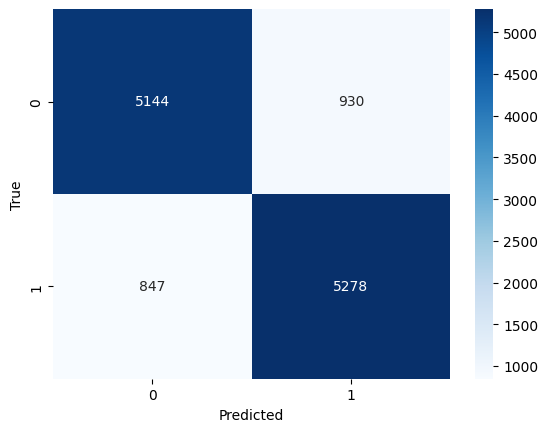

In [ ]:
metricas(y_predic, y_test)

In [ ]:
n_features = len(np.unique(x_train.columns))

cant=1000
modelSubmit = keras.Sequential([
    keras.layers.Dense(cant, activation='relu', input_shape=(n_features,)),  # Capa input con activación ReLU
    keras.layers.Dense(250, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(250, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])
# Compilar el modelo
modelSubmit.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

createSubmitOfModel(modelSubmit, f'RNA_2relu{cant}_250')

Epoch 1/15
1907/1907 [==============================] - 20s 10ms/step - loss: 0.3690 - auc: 0.9101 - accuracy: 0.8179
Epoch 2/15
1907/1907 [==============================] - 20s 11ms/step - loss: 0.3310 - auc: 0.9286 - accuracy: 0.8386
Epoch 3/15
1907/1907 [==============================] - 18s 9ms/step - loss: 0.3169 - auc: 0.9348 - accuracy: 0.8464
Epoch 4/15
1907/1907 [==============================] - 18s 9ms/step - loss: 0.3065 - auc: 0.9393 - accuracy: 0.8527
Epoch 5/15
1907/1907 [==============================] - 18s 9ms/step - loss: 0.2969 - auc: 0.9432 - accuracy: 0.8574
Epoch 6/15
1907/1907 [==============================] - 18s 10ms/step - loss: 0.2878 - auc: 0.9469 - accuracy: 0.8636
Epoch 7/15
1907/1907 [==============================] - 18s 9ms/step - loss: 0.2800 - auc: 0.9498 - accuracy: 0.8669
Epoch 8/15
1907/1907 [==============================] - 18s 9ms/step - loss: 0.2719 - auc: 0.9529 - accuracy: 0.8720
Epoch 9/15
1907/1907 [==============================] - 18s 9

###Modelo 1

Para este primer modelo de RNA decidimos utilizar 2 capas ocultas, ambas ReLU, con 500 neuronas en cada una. Para la capa de entrada tambien se tomo una ReLU, esta con 1000 neuronas.

In [40]:
n_features = len(np.unique(x_train.columns))

# Definir la arquitectura del modelo
model = keras.Sequential([
    keras.layers.Dense(1000, activation='relu', input_shape=(n_features,)),  # Capa input con activación ReLU
    keras.layers.Dense(500, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(500, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

# Entrenar el modelo
model.fit(x_train_scaled, y_train, epochs=15, batch_size=32)

Epoch 1/15
1525/1525 [==============================] - 27s 17ms/step - loss: 0.3742 - auc: 0.9081 - accuracy: 0.8155
Epoch 2/15
1525/1525 [==============================] - 25s 16ms/step - loss: 0.3362 - auc: 0.9266 - accuracy: 0.8372
Epoch 3/15
1525/1525 [==============================] - 25s 17ms/step - loss: 0.3222 - auc: 0.9327 - accuracy: 0.8434
Epoch 4/15
1525/1525 [==============================] - 26s 17ms/step - loss: 0.3114 - auc: 0.9373 - accuracy: 0.8498
Epoch 5/15
1525/1525 [==============================] - 28s 19ms/step - loss: 0.3006 - auc: 0.9419 - accuracy: 0.8577
Epoch 6/15
1525/1525 [==============================] - 26s 17ms/step - loss: 0.2914 - auc: 0.9454 - accuracy: 0.8611
Epoch 7/15
1525/1525 [==============================] - 25s 16ms/step - loss: 0.2823 - auc: 0.9488 - accuracy: 0.8657
Epoch 8/15
1525/1525 [==============================] - 26s 17ms/step - loss: 0.2730 - auc: 0.9523 - accuracy: 0.8703
Epoch 9/15
1525/1525 [==============================] - 

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1000)              68000     
                                                                 
 dense_23 (Dense)            (None, 500)               500500    
                                                                 
 dense_24 (Dense)            (None, 500)               250500    
                                                                 
 dense_25 (Dense)            (None, 1)                 501       
                                                                 
Total params: 819,501
Trainable params: 819,501
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Realizar predicciones
y_predic = model.predict(x_test_scaled)
y_predic = np.where(y_predic>0.5,1,0)

382/382 [==============================] - 1s 3ms/step


In [43]:
print(y_predic)

[[0]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6074
           1       0.86      0.85      0.85      6125

    accuracy                           0.85     12199
   macro avg       0.85      0.85      0.85     12199
weighted avg       0.85      0.85      0.85     12199



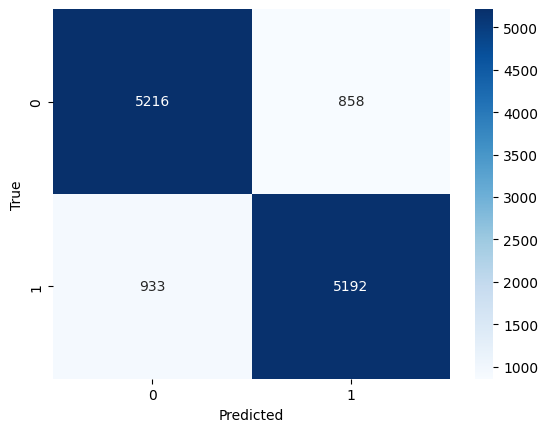

In [44]:
metricas(y_predic, y_test)

In [26]:
n_features = len(np.unique(x_train.columns))

cant=1000
modelSubmit = keras.Sequential([
    keras.layers.Dense(cant, activation='relu', input_shape=(n_features,)),  # Capa input con activación ReLU
    keras.layers.Dense(500, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(500, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])
# Compilar el modelo
modelSubmit.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

createSubmitOfModel(modelSubmit, f'RNA_2relu{cant}_500')

Epoch 1/15
1907/1907 [==============================] - 35s 17ms/step - loss: 0.3702 - auc: 0.9094 - accuracy: 0.8159
Epoch 2/15
1907/1907 [==============================] - 30s 16ms/step - loss: 0.3331 - auc: 0.9275 - accuracy: 0.8377
Epoch 3/15
1907/1907 [==============================] - 33s 17ms/step - loss: 0.3177 - auc: 0.9343 - accuracy: 0.8465
Epoch 4/15
1907/1907 [==============================] - 29s 15ms/step - loss: 0.3078 - auc: 0.9385 - accuracy: 0.8515
Epoch 5/15
1907/1907 [==============================] - 30s 16ms/step - loss: 0.2967 - auc: 0.9432 - accuracy: 0.8573
Epoch 6/15
1907/1907 [==============================] - 30s 16ms/step - loss: 0.2884 - auc: 0.9467 - accuracy: 0.8628
Epoch 7/15
1907/1907 [==============================] - 30s 15ms/step - loss: 0.2796 - auc: 0.9501 - accuracy: 0.8671
Epoch 8/15
1907/1907 [==============================] - 29s 15ms/step - loss: 0.2705 - auc: 0.9533 - accuracy: 0.8724
Epoch 9/15
1907/1907 [==============================] - 

###Modelo 2

Se cambió la distribución de neuronas en la última capa oculta disminuyendo a la mitad de la anterior

In [45]:
n_features = len(np.unique(x_train.columns))

# Definir la arquitectura del modelo
model = keras.Sequential([
    keras.layers.Dense(1000, activation='relu', input_shape=(n_features,)),  # Capa oculta con activación ReLU
    keras.layers.Dense(500, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(250, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

# Entrenar el modelo
model.fit(x_train_scaled, y_train, epochs=15, batch_size=32)

Epoch 1/15
1525/1525 [==============================] - 24s 14ms/step - loss: 0.3735 - auc: 0.9086 - accuracy: 0.8162
Epoch 2/15
1525/1525 [==============================] - 23s 15ms/step - loss: 0.3350 - auc: 0.9268 - accuracy: 0.8365
Epoch 3/15
1525/1525 [==============================] - 22s 14ms/step - loss: 0.3210 - auc: 0.9333 - accuracy: 0.8461
Epoch 4/15
1525/1525 [==============================] - 24s 16ms/step - loss: 0.3104 - auc: 0.9378 - accuracy: 0.8498
Epoch 5/15
1525/1525 [==============================] - 23s 15ms/step - loss: 0.2993 - auc: 0.9422 - accuracy: 0.8573
Epoch 6/15
1525/1525 [==============================] - 23s 15ms/step - loss: 0.2894 - auc: 0.9463 - accuracy: 0.8624
Epoch 7/15
1525/1525 [==============================] - 23s 15ms/step - loss: 0.2805 - auc: 0.9496 - accuracy: 0.8662
Epoch 8/15
1525/1525 [==============================] - 23s 15ms/step - loss: 0.2714 - auc: 0.9529 - accuracy: 0.8702
Epoch 9/15
1525/1525 [==============================] - 

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 1000)              68000     
                                                                 
 dense_27 (Dense)            (None, 500)               500500    
                                                                 
 dense_28 (Dense)            (None, 250)               125250    
                                                                 
 dense_29 (Dense)            (None, 1)                 251       
                                                                 
Total params: 694,001
Trainable params: 694,001
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Realizar predicciones
y_predic = model.predict(x_test_scaled)
y_predic = np.where(y_predic>=0.5,1,0)

382/382 [==============================] - 1s 3ms/step


In [48]:
print(y_predic)

[[0]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


              precision    recall  f1-score   support

           0       0.86      0.83      0.85      6074
           1       0.84      0.86      0.85      6125

    accuracy                           0.85     12199
   macro avg       0.85      0.85      0.85     12199
weighted avg       0.85      0.85      0.85     12199



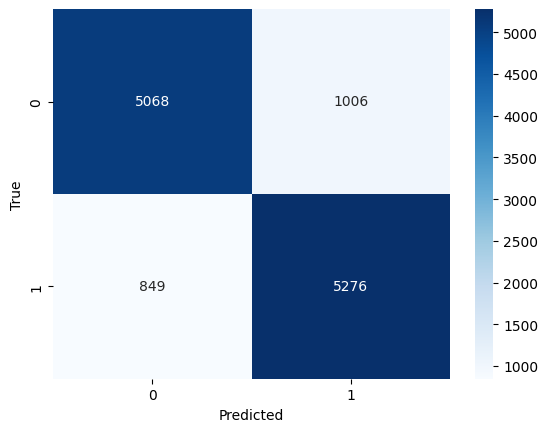

In [49]:
metricas(y_predic, y_test)

In [27]:
n_features = len(np.unique(x_train.columns))

cant=1000
# Definir la arquitectura del modelo
modelSubmit = keras.Sequential([
    keras.layers.Dense(1000, activation='relu', input_shape=(n_features,)),  # Capa oculta con activación ReLU
    keras.layers.Dense(500, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(250, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])

# Compilar el modelo
modelSubmit.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

createSubmitOfModel(modelSubmit, f'RNA_softmax_2relu_1elu_{cant}_250')

Epoch 1/15
1907/1907 [==============================] - 29s 14ms/step - loss: 0.3696 - auc: 0.9095 - accuracy: 0.8170
Epoch 2/15
1907/1907 [==============================] - 28s 15ms/step - loss: 0.3325 - auc: 0.9281 - accuracy: 0.8390
Epoch 3/15
1907/1907 [==============================] - 28s 15ms/step - loss: 0.3169 - auc: 0.9348 - accuracy: 0.8476
Epoch 4/15
1907/1907 [==============================] - 27s 14ms/step - loss: 0.3058 - auc: 0.9395 - accuracy: 0.8528
Epoch 5/15
1907/1907 [==============================] - 27s 14ms/step - loss: 0.2968 - auc: 0.9435 - accuracy: 0.8589
Epoch 6/15
1907/1907 [==============================] - 27s 14ms/step - loss: 0.2862 - auc: 0.9475 - accuracy: 0.8641
Epoch 7/15
1907/1907 [==============================] - 29s 15ms/step - loss: 0.2791 - auc: 0.9502 - accuracy: 0.8681
Epoch 8/15
1907/1907 [==============================] - 26s 14ms/step - loss: 0.2684 - auc: 0.9542 - accuracy: 0.8734
Epoch 9/15
1907/1907 [==============================] - 

###Modelo 3

Se usa la función relu como capa de entrada y luego se agregan las siguientes capas ocultas con las funciones de activación selu, elu, relu, tanh

In [50]:
n_features = len(np.unique(x_train.columns))

# Definir la arquitectura del modelo
model = keras.Sequential([
    keras.layers.Dense(1000, activation='relu', input_shape=(n_features,)),  # Capa input con activación ReLU
    keras.layers.Dense(250, activation='selu'),  # Capa oculta con activación SeLU
    keras.layers.Dense(250, activation='elu'),  # Capa oculta con activación ELU
    keras.layers.Dense(250, activation='relu'),  # Capa oculta con activación ReLU    
    keras.layers.Dense(250, activation='tanh'),  # Capa oculta con activación tanh
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

# Entrenar el modelo
model.fit(x_train_scaled, y_train, epochs=15, batch_size=32)

Epoch 1/15
1525/1525 [==============================] - 21s 13ms/step - loss: 0.3821 - auc: 0.9031 - accuracy: 0.8107
Epoch 2/15
1525/1525 [==============================] - 20s 13ms/step - loss: 0.3477 - auc: 0.9207 - accuracy: 0.8289
Epoch 3/15
1525/1525 [==============================] - 20s 13ms/step - loss: 0.3353 - auc: 0.9270 - accuracy: 0.8366
Epoch 4/15
1525/1525 [==============================] - 20s 13ms/step - loss: 0.3254 - auc: 0.9315 - accuracy: 0.8432
Epoch 5/15
1525/1525 [==============================] - 23s 15ms/step - loss: 0.3212 - auc: 0.9338 - accuracy: 0.8471
Epoch 6/15
1525/1525 [==============================] - 19s 13ms/step - loss: 0.3136 - auc: 0.9366 - accuracy: 0.8494
Epoch 7/15
1525/1525 [==============================] - 19s 12ms/step - loss: 0.3062 - auc: 0.9400 - accuracy: 0.8547
Epoch 8/15
1525/1525 [==============================] - 20s 13ms/step - loss: 0.3029 - auc: 0.9414 - accuracy: 0.8563
Epoch 9/15
1525/1525 [==============================] - 

In [51]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1000)              68000     
                                                                 
 dense_31 (Dense)            (None, 250)               250250    
                                                                 
 dense_32 (Dense)            (None, 250)               62750     
                                                                 
 dense_33 (Dense)            (None, 250)               62750     
                                                                 
 dense_34 (Dense)            (None, 250)               62750     
                                                                 
 dense_35 (Dense)            (None, 1)                 251       
                                                                 
Total params: 506,751
Trainable params: 506,751
Non-tr

In [52]:
# Realizar predicciones
y_predic = model.predict(x_test_scaled)
y_predic = np.where(y_predic>=0.5,1,0)

382/382 [==============================] - 1s 3ms/step


In [39]:
print(y_predic)

[[0]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


              precision    recall  f1-score   support

           0       0.85      0.85      0.85      6074
           1       0.85      0.85      0.85      6125

    accuracy                           0.85     12199
   macro avg       0.85      0.85      0.85     12199
weighted avg       0.85      0.85      0.85     12199



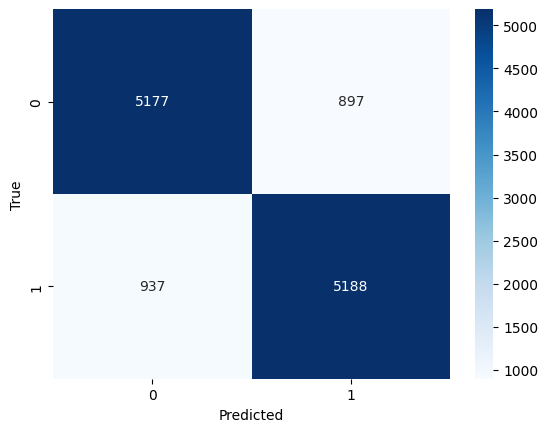

In [53]:
metricas(y_predic, y_test)

In [28]:
n_features = len(np.unique(x_train.columns))

cant=1000
modelSubmit = keras.Sequential([
    keras.layers.Dense(cant, activation='relu', input_shape=(n_features,)),  # Capa input con activación ReLU
    keras.layers.Dense(250, activation='selu'),  # Capa oculta con activación SeLU
    keras.layers.Dense(250, activation='elu'),  # Capa oculta con activación ELU
    keras.layers.Dense(250, activation='relu'),  # Capa oculta con activación ReLU    
    keras.layers.Dense(250, activation='tanh'),  # Capa oculta con activación tanh
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])
# Compilar el modelo
modelSubmit.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

createSubmitOfModel(modelSubmit, f'RNA_srelu_tan_{cant}')

Epoch 1/15
1907/1907 [==============================] - 25s 12ms/step - loss: 0.3780 - auc: 0.9055 - accuracy: 0.8119
Epoch 2/15
1907/1907 [==============================] - 22s 12ms/step - loss: 0.3493 - auc: 0.9208 - accuracy: 0.8299
Epoch 3/15
1907/1907 [==============================] - 23s 12ms/step - loss: 0.3359 - auc: 0.9269 - accuracy: 0.8370
Epoch 4/15
1907/1907 [==============================] - 22s 11ms/step - loss: 0.3262 - auc: 0.9316 - accuracy: 0.8436
Epoch 5/15
1907/1907 [==============================] - 27s 14ms/step - loss: 0.3181 - auc: 0.9352 - accuracy: 0.8486
Epoch 6/15
1907/1907 [==============================] - 23s 12ms/step - loss: 0.3145 - auc: 0.9367 - accuracy: 0.8499
Epoch 7/15
1907/1907 [==============================] - 22s 12ms/step - loss: 0.3107 - auc: 0.9385 - accuracy: 0.8523
Epoch 8/15
1907/1907 [==============================] - 23s 12ms/step - loss: 0.2993 - auc: 0.9427 - accuracy: 0.8560
Epoch 9/15
1907/1907 [==============================] - 

##Prueba de regularizaciones


Para mostrar como afectan los distintos tipos de regularizacion, utilizaremos el modelo 1 como ejemplo.

Para este primer modelo de RNA decidimos utilizar 2 capas ocultas, ambas ReLU, con 500 neuronas en cada una. Para la capa de entrada tambien se tomo una ReLU, esta con 1000 neuronas.

###L1

In [29]:
n_features = len(np.unique(x_train.columns))

# Definir la arquitectura del modelo
model = keras.Sequential([
    keras.layers.Dense(1000, activation='relu', input_shape=(n_features,),  kernel_regularizer=regularizers.l1(0.01)),  # Capa input con activación ReLU
    keras.layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l1(0.01)),  # Capa oculta con activación ReLU
    keras.layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l1(0.01)),  # Capa oculta con activación ReLU
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

# Entrenar el modelo
model.fit(x_train_scaled, y_train, epochs=15, batch_size=32)

Epoch 1/15
1525/1525 [==============================] - 30s 19ms/step - loss: 6.1969 - auc: 0.5016 - accuracy: 0.5017
Epoch 2/15
1525/1525 [==============================] - 28s 19ms/step - loss: 1.6937 - auc: 0.4991 - accuracy: 0.5016
Epoch 3/15
1525/1525 [==============================] - 32s 21ms/step - loss: 1.6933 - auc: 0.4985 - accuracy: 0.4975
Epoch 4/15
1525/1525 [==============================] - 28s 18ms/step - loss: 1.6932 - auc: 0.5019 - accuracy: 0.5029
Epoch 5/15
1525/1525 [==============================] - 28s 18ms/step - loss: 1.6932 - auc: 0.5003 - accuracy: 0.5017
Epoch 6/15
1525/1525 [==============================] - 28s 18ms/step - loss: 1.6931 - auc: 0.4998 - accuracy: 0.5007
Epoch 7/15
1525/1525 [==============================] - 28s 18ms/step - loss: 1.6931 - auc: 0.4995 - accuracy: 0.5011
Epoch 8/15
1525/1525 [==============================] - 28s 19ms/step - loss: 1.6931 - auc: 0.4986 - accuracy: 0.4960
Epoch 9/15
1525/1525 [==============================] - 

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1000)              68000     
                                                                 
 dense_15 (Dense)            (None, 500)               500500    
                                                                 
 dense_16 (Dense)            (None, 500)               250500    
                                                                 
 dense_17 (Dense)            (None, 1)                 501       
                                                                 
Total params: 819,501
Trainable params: 819,501
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Realizar predicciones
y_predic = model.predict(x_test_scaled)
y_predic = np.where(y_predic>0.5,1,0)

382/382 [==============================] - 2s 4ms/step


In [32]:
print(y_predic)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6074
           1       0.50      1.00      0.67      6125

    accuracy                           0.50     12199
   macro avg       0.25      0.50      0.33     12199
weighted avg       0.25      0.50      0.34     12199



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


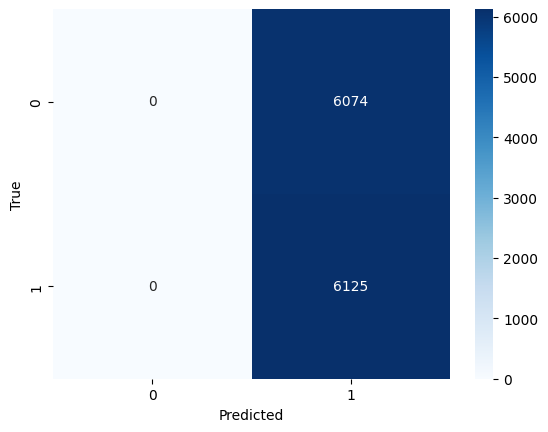

In [33]:
metricas(y_predic, y_test)

###L2

In [34]:
n_features = len(np.unique(x_train.columns))

# Definir la arquitectura del modelo
model = keras.Sequential([
    keras.layers.Dense(1000, activation='relu', input_shape=(n_features,),  kernel_regularizer=regularizers.l2(0.01)),  # Capa input con activación ReLU
    keras.layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Capa oculta con activación ReLU
    keras.layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Capa oculta con activación ReLU
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

# Entrenar el modelo
model.fit(x_train_scaled, y_train, epochs=15, batch_size=32)

Epoch 1/15
1525/1525 [==============================] - 29s 18ms/step - loss: 0.6928 - auc: 0.8938 - accuracy: 0.8009
Epoch 2/15
1525/1525 [==============================] - 26s 17ms/step - loss: 0.4198 - auc: 0.9092 - accuracy: 0.8169
Epoch 3/15
1525/1525 [==============================] - 26s 17ms/step - loss: 0.4054 - auc: 0.9142 - accuracy: 0.8232
Epoch 4/15
1525/1525 [==============================] - 27s 18ms/step - loss: 0.3990 - auc: 0.9161 - accuracy: 0.8231
Epoch 5/15
1525/1525 [==============================] - 28s 18ms/step - loss: 0.3944 - auc: 0.9178 - accuracy: 0.8266
Epoch 6/15
1525/1525 [==============================] - 27s 18ms/step - loss: 0.3930 - auc: 0.9176 - accuracy: 0.8244
Epoch 7/15
1525/1525 [==============================] - 34s 22ms/step - loss: 0.3899 - auc: 0.9190 - accuracy: 0.8275
Epoch 8/15
1525/1525 [==============================] - 28s 18ms/step - loss: 0.3888 - auc: 0.9191 - accuracy: 0.8269
Epoch 9/15
1525/1525 [==============================] - 

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1000)              68000     
                                                                 
 dense_19 (Dense)            (None, 500)               500500    
                                                                 
 dense_20 (Dense)            (None, 500)               250500    
                                                                 
 dense_21 (Dense)            (None, 1)                 501       
                                                                 
Total params: 819,501
Trainable params: 819,501
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Realizar predicciones
y_predic = model.predict(x_test_scaled)
y_predic = np.where(y_predic>0.5,1,0)

382/382 [==============================] - 1s 3ms/step


In [37]:
print(y_predic)

[[0]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


              precision    recall  f1-score   support

           0       0.79      0.88      0.83      6074
           1       0.87      0.77      0.81      6125

    accuracy                           0.82     12199
   macro avg       0.83      0.82      0.82     12199
weighted avg       0.83      0.82      0.82     12199



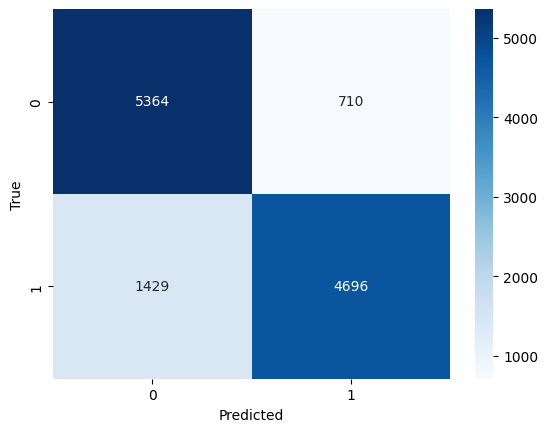

In [38]:
metricas(y_predic, y_test)

###Early stopping

Para este primer modelo de RNA decidimos utilizar 2 capas ocultas, ambas ReLU, con 500 neuronas en cada una. Para la capa de entrada tambien se tomo una ReLU, esta con 1000 neuronas.

In [ ]:
n_features = len(np.unique(x_train.columns))

# Definir la arquitectura del modelo
model = keras.Sequential([
    keras.layers.Dense(1000, activation='relu', input_shape=(n_features,)),  # Capa input con activación ReLU
    keras.layers.Dense(500, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(500, activation='relu'),  # Capa oculta con activación ReLU
    keras.layers.Dense(1, activation='sigmoid'),  # Capa de salida con activación sigmoide
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

# Definir early stopping
early_stopping = EarlyStopping(monitor='loss', patience=3)

# Entrenar el modelo
model.fit(x_train_scaled, y_train, epochs=15, batch_size=32, callbacks=[early_stopping])

Epoch 1/15
1525/1525 [==============================] - 26s 16ms/step - loss: 0.3735 - auc: 0.9079 - accuracy: 0.8146
Epoch 2/15
1525/1525 [==============================] - 26s 17ms/step - loss: 0.3356 - auc: 0.9260 - accuracy: 0.8352
Epoch 3/15
1525/1525 [==============================] - 26s 17ms/step - loss: 0.3233 - auc: 0.9322 - accuracy: 0.8436
Epoch 4/15
1525/1525 [==============================] - 25s 17ms/step - loss: 0.3102 - auc: 0.9376 - accuracy: 0.8502
Epoch 5/15
1525/1525 [==============================] - 24s 16ms/step - loss: 0.3000 - auc: 0.9419 - accuracy: 0.8550
Epoch 6/15
1525/1525 [==============================] - 25s 16ms/step - loss: 0.2914 - auc: 0.9454 - accuracy: 0.8610
Epoch 7/15
1525/1525 [==============================] - 27s 17ms/step - loss: 0.2826 - auc: 0.9488 - accuracy: 0.8654
Epoch 8/15
1525/1525 [==============================] - 25s 17ms/step - loss: 0.2727 - auc: 0.9523 - accuracy: 0.8698
Epoch 9/15
1525/1525 [==============================] - 

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 1000)              68000     
                                                                 
 dense_51 (Dense)            (None, 500)               500500    
                                                                 
 dense_52 (Dense)            (None, 500)               250500    
                                                                 
 dense_53 (Dense)            (None, 1)                 501       
                                                                 
Total params: 819,501
Trainable params: 819,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Realizar predicciones
y_predic = model.predict(x_test_scaled)
y_predic = np.where(y_predic>0.5,1,0)

382/382 [==============================] - 1s 4ms/step


In [ ]:
print(y_predic)

[[0]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


              precision    recall  f1-score   support

           0       0.86      0.84      0.85      6074
           1       0.85      0.86      0.85      6125

    accuracy                           0.85     12199
   macro avg       0.85      0.85      0.85     12199
weighted avg       0.85      0.85      0.85     12199



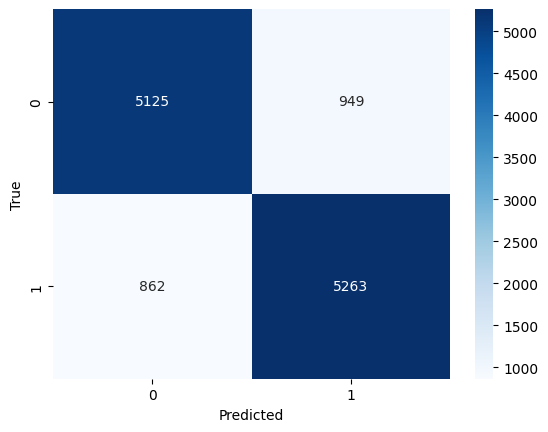

In [ ]:
metricas(y_predic, y_test)

###Dropout

Para este primer modelo de RNA decidimos utilizar 2 capas ocultas, ambas ReLU, con 500 neuronas en cada una. Para la capa de entrada tambien se tomo una ReLU, esta con 1000 neuronas.

In [ ]:
n_features = len(np.unique(x_train.columns))

# Definir la arquitectura del modelo
model = keras.Sequential()
model.add(Dense(1000, activation='relu', input_shape=(n_features,)))
model.add(Dropout(0.5))  # Capa Dropout con una tasa de dropout de 0.5
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))  # Capa Dropout con una tasa de dropout de 0.5
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))  # Capa Dropout con una tasa de dropout de 0.5
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

# Entrenar el modelo
model.fit(x_train_scaled, y_train, epochs=15, batch_size=32)

Epoch 1/15
1525/1525 [==============================] - 29s 18ms/step - loss: 0.4067 - auc: 0.8905 - accuracy: 0.7979
Epoch 2/15
1525/1525 [==============================] - 28s 19ms/step - loss: 0.3680 - auc: 0.9119 - accuracy: 0.8204
Epoch 3/15
1525/1525 [==============================] - 29s 19ms/step - loss: 0.3596 - auc: 0.9170 - accuracy: 0.8252
Epoch 4/15
1525/1525 [==============================] - 28s 18ms/step - loss: 0.3526 - auc: 0.9198 - accuracy: 0.8284
Epoch 5/15
1525/1525 [==============================] - 28s 18ms/step - loss: 0.3462 - auc: 0.9231 - accuracy: 0.8335
Epoch 6/15
1525/1525 [==============================] - 30s 20ms/step - loss: 0.3438 - auc: 0.9246 - accuracy: 0.8352
Epoch 7/15
1525/1525 [==============================] - 29s 19ms/step - loss: 0.3398 - auc: 0.9262 - accuracy: 0.8364
Epoch 8/15
1525/1525 [==============================] - 30s 20ms/step - loss: 0.3365 - auc: 0.9275 - accuracy: 0.8385
Epoch 9/15
1525/1525 [==============================] - 

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 1000)              68000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_55 (Dense)            (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_56 (Dense)            (None, 500)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_57 (Dense)            (None, 1)               

In [ ]:
# Realizar predicciones
y_predic = model.predict(x_test_scaled)
y_predic = np.where(y_predic>0.5,1,0)

382/382 [==============================] - 1s 4ms/step


In [ ]:
print(y_predic)

[[0]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


              precision    recall  f1-score   support

           0       0.83      0.87      0.85      6074
           1       0.86      0.83      0.85      6125

    accuracy                           0.85     12199
   macro avg       0.85      0.85      0.85     12199
weighted avg       0.85      0.85      0.85     12199



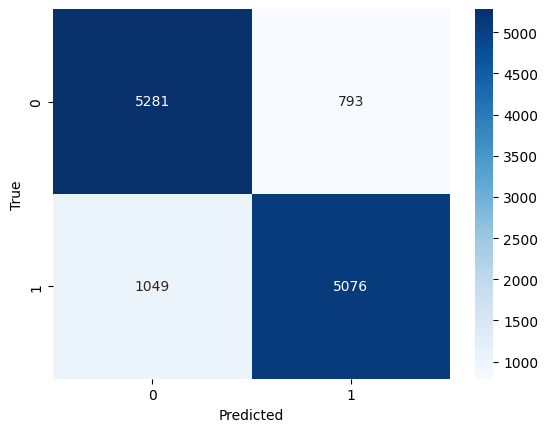

In [ ]:
metricas(y_predic, y_test)